## Pumila14
* 入力: 自フィールドのみ、1手先を計算
* 報酬: 自分のスコア
* 1層300ノード、Sigmoid
* 100000ステップ学習
    * 100ステップで盤面リセット
#### 結果
* 1,2連鎖で消してしまう
* たまに4連鎖とか

In [1]:
import sys
import os
build_path = os.path.join(os.getcwd(), "..", "build")

In [2]:
os.getpid()

1111089

In [ ]:
# build_type = "Release"
build_type = "RelWithDebInfo"
import psutil
!cmake .. -B {build_path} -DPYTHON_EXECUTABLE={sys.executable} -Wno-dev -DCMAKE_BUILD_TYPE={build_type}
!cmake --build {build_path} -t pypumila -j {psutil.cpu_count()}

In [4]:
os.chdir(build_path)
import pumila
# to reload pypumila, restart python kernel.
# importlib.reload(pypumila) <- does not work

import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib
import matplotlib.pyplot as plt
import torch

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
num_step = 100000
learning = pumila.Learning(
    Net=pumila.Net14,
    eps_decay=50000,
)
print(learning.device)
sim = pumila.GameSim()
sim.enable_garbage = False

cpu


In [6]:
from concurrent.futures import ThreadPoolExecutor
pool = ThreadPoolExecutor()

In [7]:
from collections import deque
reset_step = 100
steps = deque()
rewards = []
def sim_step():
    data = learning.get_step(sim)
    steps.append(data.step)
    action = learning.select_action(data)
    learning.push_step(data, action)
    sim.put(pumila.actions[action])
    sim.step()
    while sim.phase_get() != pumila.GameSim.PhaseEnum.free:
        sim.step()
    if sim.is_over or sim.step_count >= reset_step:
        sim.reset()
    while len(steps) and steps[0].done():
        step = steps.popleft()
        rewards.append(learning.policy_net.reward(step))

In [8]:
diffs = []
for i_episode in tqdm(range(num_step)):
    ss = pool.submit(sim_step)
    batch = learning.get_batch()
    if batch:
        q = pool.submit(learning.calc_q_batch, batch)
        expected_q = pool.submit(learning.calc_expected_q_batch, batch)
        diffs.append((q.result() - expected_q.result()).abs().mean().tolist())
        learning.optimize_batch(q.result(), expected_q.result())
        learning.update_target_net()
    ss.result()

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
torch.save(learning.policy_net, "pumila14.pt")

In [30]:
import pickle
with open("pumila14_rewards.pkl", "wb") as f:
    pickle.dump(rewards, f)
with open("pumila14_diffs.pkl", "wb") as f:
    pickle.dump(diffs, f)

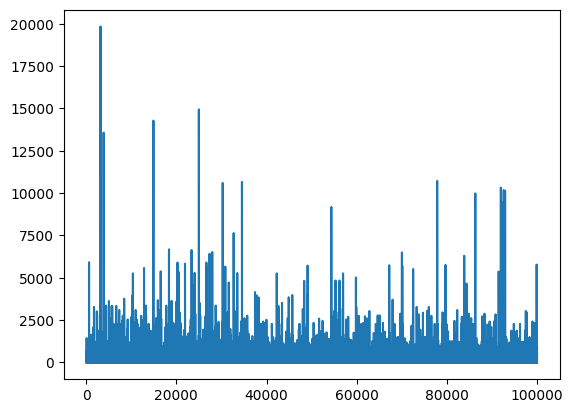

In [10]:
plt.plot(rewards)

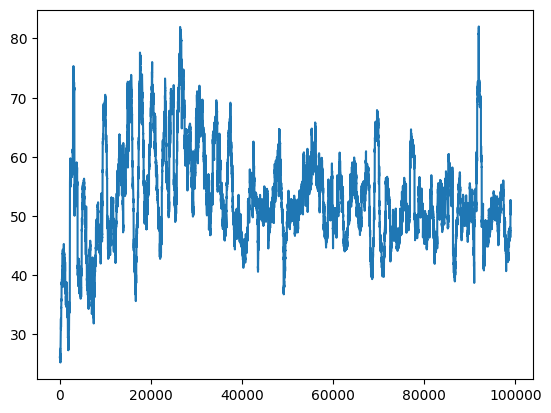

In [19]:
plt.plot(np.convolve(np.array(rewards), np.ones(1000) / 1000, mode="valid"))

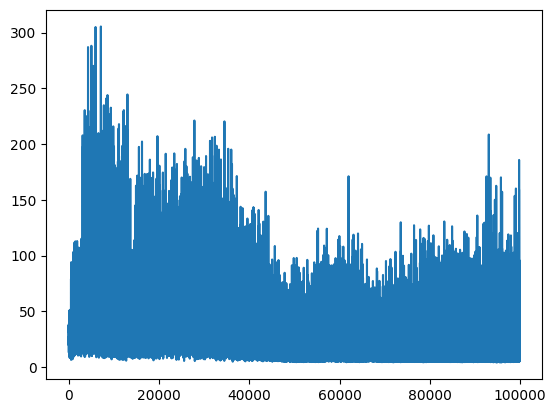

In [20]:
plt.plot(diffs)

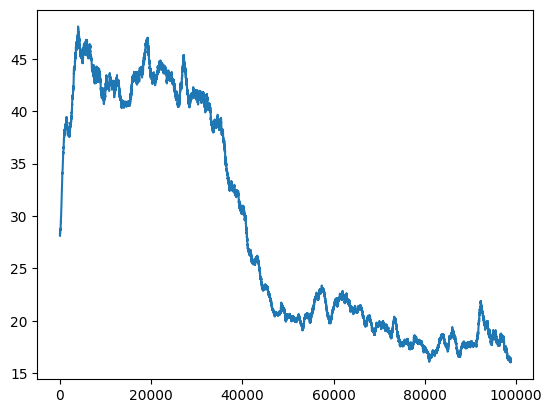

In [21]:
plt.plot(np.convolve(np.array(diffs), np.ones(1000) / 1000, mode="valid"))

In [22]:
win = pumila.Window()
sim = pumila.GameSim()
win.set_sim([(sim, False)])

In [ ]:
import time
put_done = False
while True:
    time.sleep(0.016)
    if sim.phase_get() == pumila.GameSim.PhaseEnum.free:
        if not put_done:
            data = learning.get_step(sim)
            action = learning.select_action(data, 0)
            sim.soft_put(pumila.actions[action])
            # print(data.feat[action, 6*13*4*2:])
            put_done = True
    else:
        put_done = False
    sim.step()
    win.step()

In [25]:
sim.reset()